In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from IPython.display import Image

import src
from src.reload import deep_reload

This notebook shows an example of electricity Locational Marginal Prices (LMPs) for a 3 bus scenario with renewables and battery storage.

In the first example a 3 bus scenario is considered contining a power generation node, a residential node, and a commercial node. Solar power is present at the latter nodes and the residential node contains static, dispatchable battery storage.

[Text(0.5, 0, 'Time [h]'), Text(0, 0.5, 'Load Portion of Max [-]')]

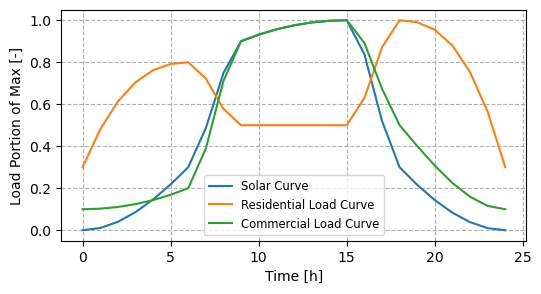

In [2]:
# Defining exogenous
from scipy.interpolate import PchipInterpolator

time = np.arange(0, 25, 1)

solar_curve = PchipInterpolator([0, 6, 9, 15, 18, 24], [0, .3, .9, 1, .3, 0])(time)

residential_load_curve = PchipInterpolator(
    [0, 6, 9, 15, 18, 24], [.3, .8, .5, .5, 1, .3])(time)

commercial_load_curve = PchipInterpolator(
    [0, 6, 9, 15, 18, 24], [.1, .2, .9, 1, .5, .1])(time)

fig, ax = plt.subplots(figsize = (6,3))

ax.plot(time, solar_curve, label = 'Solar Curve')
ax.plot(time, residential_load_curve, label = 'Residential Load Curve')
ax.plot(time, commercial_load_curve, label = 'Commercial Load Curve')

ax.legend(fontsize = 'small')
ax.grid(ls = '--')
ax.set(**{'xlabel': 'Time [h]', 'ylabel': 'Load Portion of Max [-]'})

In [3]:
# Generating graph - solar + static storage - demand should be negative
deep_reload(src)

nodes = []

# Buses
nodes.append({'id': 'bus_0', 'dependents': [
    {'id': 'gen_0', 'type': 'generation', 'cost': 10},
    {'id': 'dis_0', 'type': 'dissipation'},
    ]})

nodes.append({'id': 'bus_1', 'dependents': [
    {'id': 'solar_1', 'type': 'load', 'value': solar_curve * 10},
    {'id': 'demand_1', 'type': 'load', 'value': residential_load_curve * -10},
    {'id': 'battery_1', 'type': 'storage','capacity': 100, 'bounds': (.2, .9), 'limit': .1},
    {'id': 'dis_1', 'type': 'dissipation'},
    ]})

nodes.append({'id': 'bus_2', 'dependents': [
    {'id': 'solar_2', 'type': 'load', 'value': solar_curve * 5},
    {'id': 'demand_2', 'type': 'load', 'value': commercial_load_curve * -10},
    {'id': 'dis_2', 'type': 'dissipation'},
    ]})

links = []

eff = .9
sus = 1

# Buses to buses
links.append({'source': 'bus_0' ,'target': 'bus_1', 'susceptance': sus, 'efficiency': eff,
              'type': 'line'})
links.append({'source': 'bus_0' ,'target': 'bus_2', 'susceptance': sus, 'efficiency': eff,
              'type': 'line'})
links.append({'source': 'bus_1' ,'target': 'bus_2', 'susceptance': sus, 'efficiency': eff,
              'type': 'line'})

# links = src.optimization.process_links(links)

nlg = {'nodes': nodes, 'links': links}
graph = src.graph.graph_from_nlg(nlg, directed = True, multigraph = False)

In [4]:
deep_reload(src)

opf = src.optimization.DC_OPF(graph, time)

solver_kwargs={'_name': 'cbc', 'executable': 'src/cbc'}

opf.solve(**solver_kwargs)

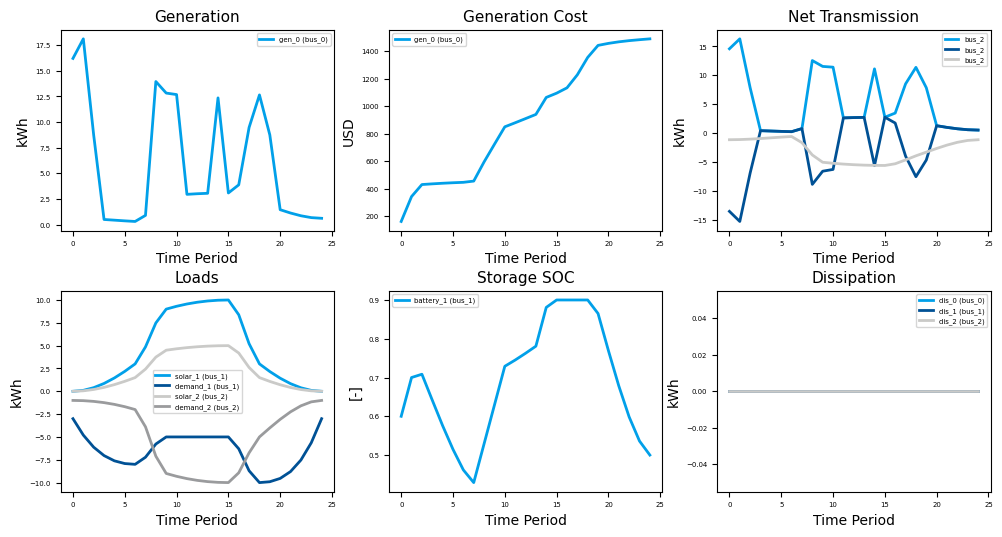

In [5]:
deep_reload(src)

kw = {
    'figure': {
        'figsize': (12,6),
        'gridspec_kw': {
            'hspace': .3,
            'wspace': .2,
        }
    },
    'plot': {
        'linewidth': 2,
    },
    'axes': {
        'facecolor': 'white',
    },
    'prop_cycle': src.figures.colors['sae'],
    # 'prop_cycle': src.figures.ReturnColorMap('viridis')(np.linspace(0,1,5)),
    # 'prop_cycle': src.figures.ReturnColorMap(src.figures.colors['trb'])(np.linspace(0,1,5)),
}

fig = src.figures.PlotDashboard(opf.graph, opf.results, opf.time, **kw)

The second example contains all elements of the first but also includes an electric vehicle which can plug in at home or work. The vehicle commutes from the residential node to the commercial node during the day.

[Text(0.5, 0, 'Time [h]'), Text(0, 0.5, 'Load Portion of Max [-]')]

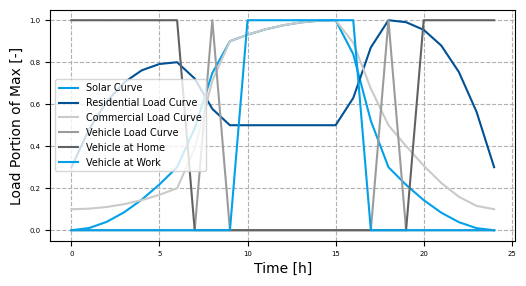

In [6]:
# Defining exogenous
from scipy.interpolate import PchipInterpolator

time = np.arange(0, 25, 1)

solar_curve = PchipInterpolator([0, 6, 9, 15, 18, 24], [0, .3, .9, 1, .3, 0])(time)

residential_load_curve = PchipInterpolator(
    [0, 6, 9, 15, 18, 24], [.3, .8, .5, .5, 1, .3])(time)

commercial_load_curve = PchipInterpolator(
    [0, 6, 9, 15, 18, 24], [.1, .2, .9, 1, .5, .1])(time)

vehicle_load_curve = PchipInterpolator(
    [0, 7, 8, 9, 17, 18, 19, 24], [0, 0, 1, 0, 0, 1, 0, 0])(time)

vehicle_at_home = np.array([1] * 7 + [0] * 13  + [1] * 5)
vehicle_at_work = np.array([0] * 10 + [1] * 7  + [0] * 8)

fig, ax = plt.subplots(figsize = (6,3))

ax.plot(time, solar_curve, label = 'Solar Curve')
ax.plot(time, residential_load_curve, label = 'Residential Load Curve')
ax.plot(time, commercial_load_curve, label = 'Commercial Load Curve')
ax.plot(time, vehicle_load_curve, label = 'Vehicle Load Curve')
ax.plot(time, vehicle_at_home, label = 'Vehicle at Home')
ax.plot(time, vehicle_at_work, label = 'Vehicle at Work')

ax.legend(fontsize = 'x-small')
ax.grid(ls = '--')
ax.set(**{'xlabel': 'Time [h]', 'ylabel': 'Load Portion of Max [-]'})

In [7]:
# Generating graph - solar + static storage
deep_reload(src)

nodes = []

# Buses
nodes.append({'id': 'bus_0', 'dependents': [
    {'id': 'gen_0', 'type': 'generation', 'cost': 10},
    {'id': 'dis_0', 'type': 'dissipation'},
    ]})

nodes.append({'id': 'bus_1', 'dependents': [
    {'id': 'solar_1', 'type': 'load', 'value': solar_curve * 10},
    {'id': 'demand_1', 'type': 'load', 'value': residential_load_curve * -10},
    {'id': 'dis_1', 'type': 'dissipation'},
    # {'id': 'battery_1', 'type': 'storage','capacity': 10},
    ]})

nodes.append({'id': 'bus_2', 'dependents': [
    {'id': 'solar_2', 'type': 'load', 'value': solar_curve * 5},
    {'id': 'demand_2', 'type': 'load', 'value': commercial_load_curve * -10},
    {'id': 'dis_2', 'type': 'dissipation'},
    ]})

nodes.append({'id': 'vehicle_1', 'dependents': [
    {'id': 'demand_v_1', 'type': 'load', 'value': vehicle_load_curve * -1},
    {'id': 'battery_v_1', 'type': 'storage', 'capacity': 5,
     'initial': .9, 'final': .9, 'bounds': (.2,.9)},
    {'id': 'dis_v_1', 'type': 'dissipation'},
    ]})

links = []

eff = 1
sus = 1

# Buses to buses
links.append({'source': 'bus_0' ,'target': 'bus_1', 'susceptance': sus, 'efficiency': eff})
links.append({'source': 'bus_0' ,'target': 'bus_2', 'susceptance': sus, 'efficiency': eff})
links.append({'source': 'bus_1' ,'target': 'bus_2', 'susceptance': sus, 'efficiency': eff})

unplugged = (0, 0)
one_way = (0, np.inf)
two_way = (-np.inf, np.inf)

vehicle_at_home_limits = np.array([one_way] * 7 + [unplugged] * 13  + [one_way] * 5)
vehicle_at_work_limits = np.array([unplugged] * 10 + [one_way] * 7  + [unplugged] * 8)
vehicle_at_work_limits = np.array([unplugged] * 10 + [two_way] * 7  + [unplugged] * 8)

links.append({'source': 'bus_1' ,'target': 'vehicle_1',
              'susceptance': sus, 'efficiency': eff, 'limit': vehicle_at_home_limits, 
             })


links.append({'source': 'bus_2' ,'target': 'vehicle_1',
              'susceptance': sus, 'efficiency': eff, 'limit': vehicle_at_work_limits,
             })

nlg = {'nodes': nodes, 'links': links}
graph = src.graph.graph_from_nlg(nlg, directed = True, multigraph = False)

In [8]:
deep_reload(src)

opf = src.optimization.DC_OPF(graph, time)

solver_kwargs={'_name': 'cbc', 'executable': 'src/cbc'}

opf.solve(**solver_kwargs)

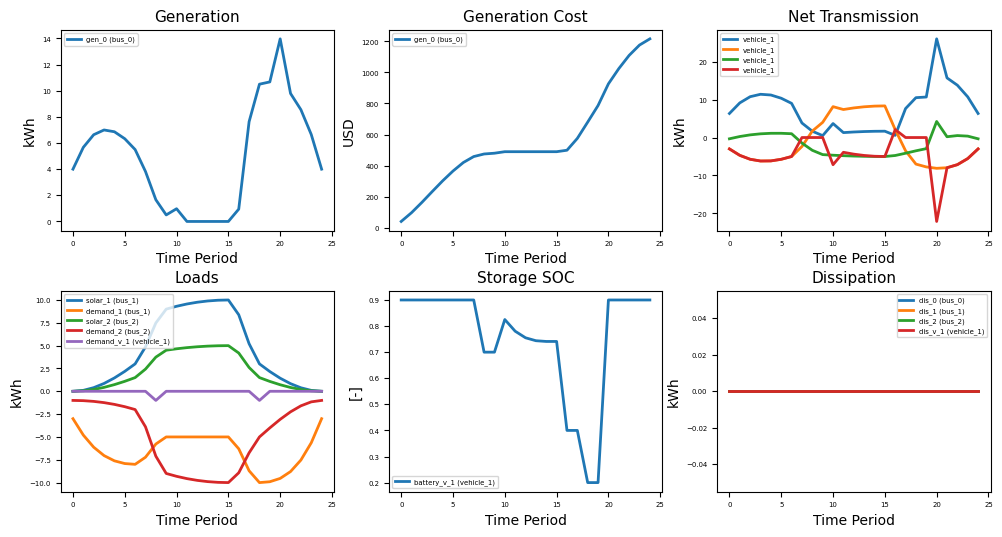

In [9]:
deep_reload(src)

kw = {
    'figure': {
        'figsize': (12,6),
        'gridspec_kw': {
            'hspace': .3,
            'wspace': .2,
        }
    },
    'plot': {
        'linewidth': 2,
    },
    'axes': {
        'facecolor': 'white',
    },
    # 'prop_cycle': src.figures.colors['sae'],
    # 'prop_cycle': src.figures.ReturnColorMap('viridis')(np.linspace(0,1,5)),
    # 'prop_cycle': src.figures.ReturnColorMap(src.figures.colors['trb'])(np.linspace(0,1,5)),
}

fig = src.figures.PlotDashboard(opf.graph, opf.results, opf.time, **kw)

In [10]:
# Generating graph - solar + static storage
deep_reload(src)

nodes = []

# Buses
nodes.append({'id': 'bus_0', 'dependents': [
    {'id': 'gen_0', 'type': 'generation', 'cost': 10},
    {'id': 'dis_0', 'type': 'dissipation'},
    ]})

nodes.append({'id': 'bus_1', 'dependents': [
    {'id': 'solar_1', 'type': 'load', 'value': solar_curve * 10},
    {'id': 'demand_1', 'type': 'load', 'value': residential_load_curve * -10},
    {'id': 'dis_1', 'type': 'dissipation'},
    # {'id': 'battery_1', 'type': 'storage','capacity': 10},
    ]})

nodes.append({'id': 'bus_2', 'dependents': [
    {'id': 'solar_2', 'type': 'load', 'value': solar_curve * 5},
    {'id': 'demand_2', 'type': 'load', 'value': commercial_load_curve * -10},
    {'id': 'dis_2', 'type': 'dissipation'},
    ]})

nodes.append({'id': 'vehicle_1', 'dependents': [
    {'id': 'demand_v_1', 'type': 'load', 'value': vehicle_load_curve * -1},
    {'id': 'battery_v_1', 'type': 'storage', 'capacity': 5,
     'initial': .9, 'final': .9, 'bounds': (.2,.9)},
    {'id': 'dis_v_1', 'type': 'dissipation'},
    ]})

links = []

eff = 1
sus = 1

# Buses to buses
links.append({'source': 'bus_0' ,'target': 'bus_1', 'susceptance': sus, 'efficiency': eff})
links.append({'source': 'bus_0' ,'target': 'bus_2', 'susceptance': sus, 'efficiency': eff})
links.append({'source': 'bus_1' ,'target': 'bus_2', 'susceptance': sus, 'efficiency': eff})

unplugged = (0, 0)
one_way = (0, np.inf)
two_way = (-np.inf, np.inf)

vehicle_at_home_limits = np.array([two_way] * 7 + [unplugged] * 13  + [two_way] * 5)
# vehicle_at_work_limits = np.array([unplugged] * 10 + [one_way] * 7  + [unplugged] * 8)
vehicle_at_work_limits = np.array([unplugged] * 10 + [two_way] * 7  + [unplugged] * 8)

links.append({'source': 'bus_1' ,'target': 'vehicle_1',
              'susceptance': sus, 'efficiency': eff, 'limit': vehicle_at_home_limits, 
             })


links.append({'source': 'bus_2' ,'target': 'vehicle_1',
              'susceptance': sus, 'efficiency': eff, 'limit': vehicle_at_work_limits,
             })

nlg = {'nodes': nodes, 'links': links}
graph = src.graph.graph_from_nlg(nlg, directed = True, multigraph = False)

In [11]:
deep_reload(src)

opf = src.optimization.DC_OPF(graph, time)

solver_kwargs={'_name': 'cbc', 'executable': 'src/cbc'}

opf.solve(**solver_kwargs)

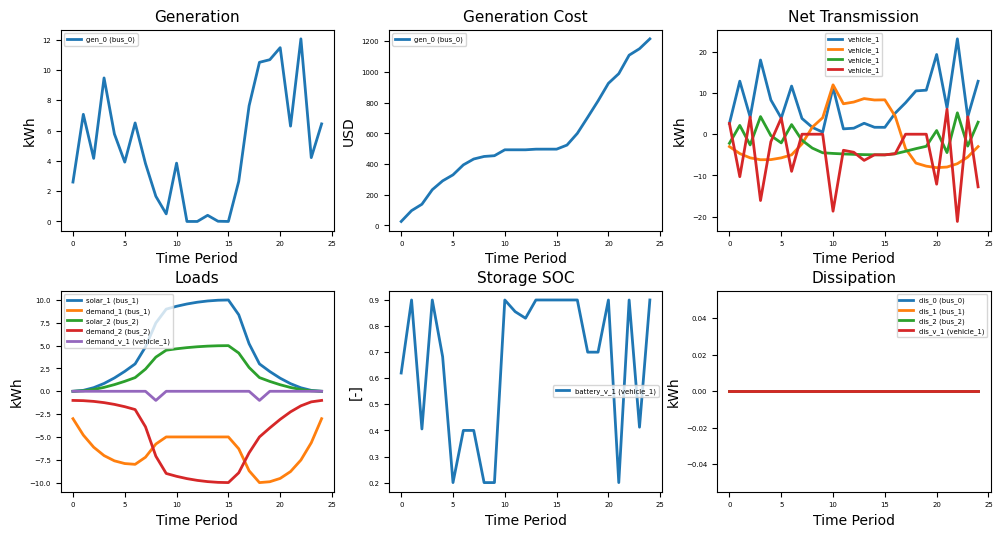

In [12]:
deep_reload(src)

kw = {
    'figure': {
        'figsize': (12,6),
        'gridspec_kw': {
            'hspace': .3,
            'wspace': .2,
        }
    },
    'plot': {
        'linewidth': 2,
    },
    'axes': {
        'facecolor': 'white',
    },
    # 'prop_cycle': src.figures.colors['sae'],
    # 'prop_cycle': src.figures.ReturnColorMap('viridis')(np.linspace(0,1,5)),
    # 'prop_cycle': src.figures.ReturnColorMap(src.figures.colors['trb'])(np.linspace(0,1,5)),
}

fig = src.figures.PlotDashboard(opf.graph, opf.results, opf.time, **kw)

In [13]:
# Generating graph - solar + static storage
deep_reload(src)

nodes = []

# Buses
nodes.append({'id': 'bus_0', 'dependents': [
    {'id': 'gen_0', 'type': 'generation', 'cost': 10},
    {'id': 'dis_0', 'type': 'dissipation'},
    ]})

nodes.append({'id': 'bus_1', 'dependents': [
    {'id': 'solar_1', 'type': 'load', 'value': solar_curve * 10},
    {'id': 'demand_1', 'type': 'load', 'value': residential_load_curve * -10},
    {'id': 'dis_1', 'type': 'dissipation'},
    {'id': 'battery_1', 'type': 'storage','capacity': 10},
    ]})

nodes.append({'id': 'bus_2', 'dependents': [
    {'id': 'solar_2', 'type': 'load', 'value': solar_curve * 5},
    {'id': 'demand_2', 'type': 'load', 'value': commercial_load_curve * -10},
    {'id': 'dis_2', 'type': 'dissipation'},
    ]})

nodes.append({'id': 'vehicle_1', 'dependents': [
    {'id': 'demand_v_1', 'type': 'load', 'value': vehicle_load_curve * -1},
    {'id': 'battery_v_1', 'type': 'storage', 'capacity': 5,
     'initial': .9, 'final': .9, 'bounds': (.2,.9)},
    {'id': 'dis_v_1', 'type': 'dissipation'},
    ]})

links = []

eff = 1
sus = 1

# Buses to buses
links.append({'source': 'bus_0' ,'target': 'bus_1', 'susceptance': sus, 'efficiency': eff})
links.append({'source': 'bus_0' ,'target': 'bus_2', 'susceptance': sus, 'efficiency': eff})
links.append({'source': 'bus_1' ,'target': 'bus_2', 'susceptance': sus, 'efficiency': eff})

unplugged = (0, 0)
one_way = (0, np.inf)
two_way = (-np.inf, np.inf)

vehicle_at_home_limits = np.array([one_way] * 7 + [unplugged] * 13  + [one_way] * 5)
# vehicle_at_work_limits = np.array([unplugged] * 10 + [one_way] * 7  + [unplugged] * 8)
vehicle_at_work_limits = np.array([unplugged] * 10 + [two_way] * 7  + [unplugged] * 8)

links.append({'source': 'bus_1' ,'target': 'vehicle_1',
              'susceptance': sus, 'efficiency': eff, 'limit': vehicle_at_home_limits, 
             })


links.append({'source': 'bus_2' ,'target': 'vehicle_1',
              'susceptance': sus, 'efficiency': eff, 'limit': vehicle_at_work_limits,
             })

nlg = {'nodes': nodes, 'links': links}
graph = src.graph.graph_from_nlg(nlg, directed = True, multigraph = False)

In [14]:
deep_reload(src)

opf = src.optimization.DC_OPF(graph, time)

solver_kwargs={'_name': 'cbc', 'executable': 'src/cbc'}

opf.solve(**solver_kwargs)

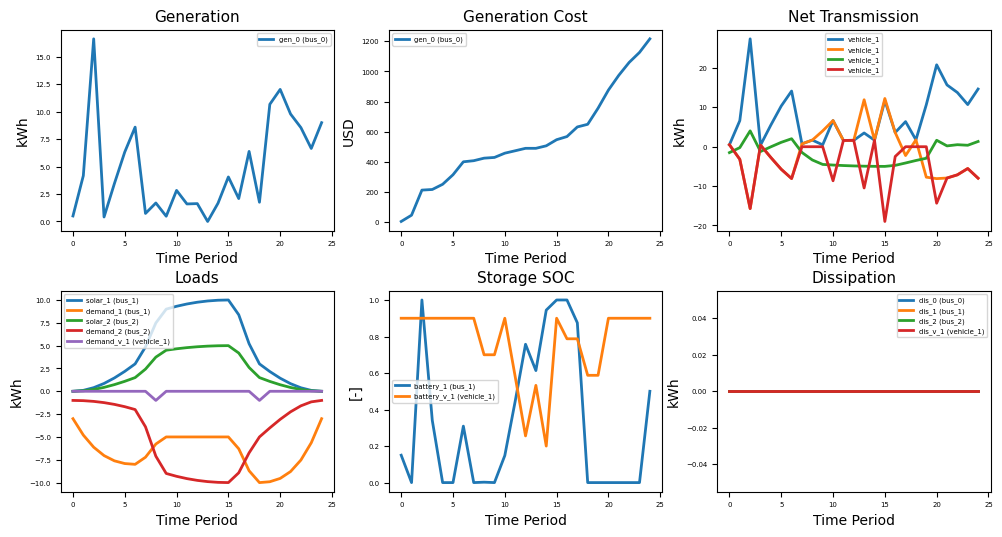

In [15]:
deep_reload(src)

kw = {
    'figure': {
        'figsize': (12,6),
        'gridspec_kw': {
            'hspace': .3,
            'wspace': .2,
        }
    },
    'plot': {
        'linewidth': 2,
    },
    'axes': {
        'facecolor': 'white',
    },
    # 'prop_cycle': src.figures.colors['sae'],
    # 'prop_cycle': src.figures.ReturnColorMap('viridis')(np.linspace(0,1,5)),
    # 'prop_cycle': src.figures.ReturnColorMap(src.figures.colors['trb'])(np.linspace(0,1,5)),
}

fig = src.figures.PlotDashboard(opf.graph, opf.results, opf.time, **kw)